In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

tf.set_random_seed(777)

1.12.0
2.1.6-tf


## Dataset

In [3]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Model Function

In [4]:
def model(image, drop_rate=0.):
    with tf.variable_scope('model'):
        L1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(images)
        L1 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L1)

        L2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(L1)
        L2 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L2)

        L3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(L2)
        L3 = keras.layers.MaxPool2D(pool_size=[2, 2], padding='SAME', strides=2)(L2)
        
        L3_flat = keras.layers.Flatten()(L3)
        L4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(L3_flat)
        L4 = keras.layers.Dropout(rate=drop_rate)(L4)

        logits = keras.layers.Dense(units=10)(L4)
    
        return logits

## Loss Function

In [5]:
def loss_fn(logits, labels, learning_rate=0.001):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=labels))
    return loss   

## Caculating Accuracy

In [6]:
def evaluate(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## Hyper Parameters

In [7]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

## Dataset & Iterator

In [8]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(
                buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
    
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

images, labels = iterator.get_next()

train_init = iterator.make_initializer(train_dataset)
test_init = iterator.make_initializer(test_dataset)

## Dropout(Drop) Ratio

In [9]:
drop_rate = tf.placeholder(tf.float32)

## Optimizer

In [10]:
logits = model(images)

loss = loss_fn(logits, labels)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

accuracy = evaluate(logits, labels)

## Training

In [11]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

In [12]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(train_images.shape[0] / batch_size)
    total_batch_test = int(test_images.shape[0] / batch_size)
    
    sess.run(train_init)
    for i in range(total_batch):
        acc, c, _ = sess.run([accuracy, loss, optimizer], feed_dict={drop_rate:0.3})
        avg_cost += c / total_batch
        avg_train_acc += acc / total_batch
        
    sess.run(test_init)        
    for i in range(total_batch_test):
        acc = sess.run(accuracy)
        avg_test_acc += acc / total_batch_test

    print('Epoch:', '{}'.format(epoch + 1), 'cost =', '{:.8f}'.format(avg_cost), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 cost = 0.21484128 train accuracy =  0.9344 test accuracy =  0.9812
Epoch: 2 cost = 0.05737037 train accuracy =  0.9819 test accuracy =  0.9885
Epoch: 3 cost = 0.04009862 train accuracy =  0.9872 test accuracy =  0.9903
Epoch: 4 cost = 0.03029773 train accuracy =  0.9907 test accuracy =  0.9910
Epoch: 5 cost = 0.02392789 train accuracy =  0.9928 test accuracy =  0.9908
Epoch: 6 cost = 0.01939129 train accuracy =  0.9939 test accuracy =  0.9906
Epoch: 7 cost = 0.01665245 train accuracy =  0.9946 test accuracy =  0.9905
Epoch: 8 cost = 0.01330909 train accuracy =  0.9959 test accuracy =  0.9907
Epoch: 9 cost = 0.01141668 train accuracy =  0.9963 test accuracy =  0.9914
Epoch: 10 cost = 0.00969391 train accuracy =  0.9969 test accuracy =  0.9919
Epoch: 11 cost = 0.00900391 train accuracy =  0.9968 test accuracy =  0.9916
Epoch: 12 cost = 0.00826956 train accuracy =  0.9974 test accuracy =  0.9925
Epoch: 13 cost = 0.00690772 train accuracy =  0.

## Visualizing Results

In [13]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(10), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

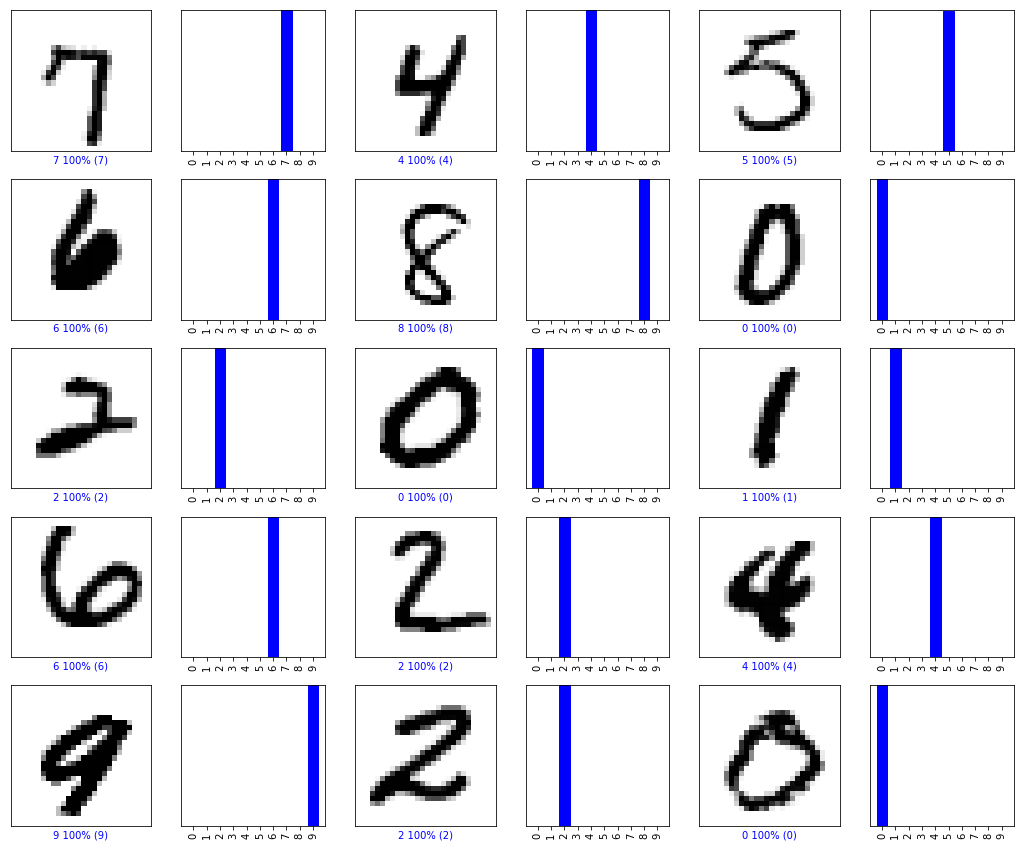

In [14]:
prob = tf.nn.softmax(logits)
#sess.run(test_init)
imgs, lbs = sess.run([images, labels])
predictions = sess.run(prob, feed_dict={images:imgs, labels:lbs})
imgs = np.reshape(imgs, (-1, 28, 28))
lbs = np.argmax(lbs, axis=-1)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, lbs, imgs)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, lbs)